https://arxiv.org/pdf/1704.04110.pdf

https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb

TODO:

- scale before computing loss

In [1]:
import pandas as pd

d = pd.read_csv('LD2011_2014.txt', sep=';', thousands=',', index_col=0, )
d.index = pd.to_datetime(d.index)
d.shape

(140256, 370)

In [2]:
d.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [3]:
d = d.resample('H', how='sum')
d.head()

/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [4]:
d.shape

(35065, 370)

In [5]:
# hopw many training examples total
import numpy as np
sum(d.apply(lambda s: np.argwhere(s > 0).reshape(-1).max() - np.argwhere(s > 0).reshape(-1).min()))

/Users/dgates/venvs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


10463878

In [6]:
# all observations are 1 hour intervals
pd.Series(d.index).diff().unique()

array([        'NaT', 3600000000000], dtype='timedelta64[ns]')

In [7]:
for c in d.columns:
    d[c] = d[c].astype(float)
d.dtypes

MT_001    float64
MT_002    float64
MT_003    float64
MT_004    float64
MT_005    float64
           ...   
MT_366    float64
MT_367    float64
MT_368    float64
MT_369    float64
MT_370    float64
Length: 370, dtype: object

In [8]:
d.index.min(), d.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'))

In [9]:
d.shape

(35065, 370)

In [10]:
d.sum(axis=0)

MT_001    1.899547e+19
MT_002    2.755961e+19
MT_003    2.490666e+19
MT_004    5.058810e+19
MT_005    4.527706e+19
              ...     
MT_366    4.462558e+19
MT_367    5.406011e+19
MT_368    3.381737e+19
MT_369    6.853980e+19
MT_370    1.331800e+19
Length: 370, dtype: float64

In [11]:
d.isnull().any().any()

False

# feature engineering

In [12]:
np.argmax((d.values > 0), axis=0)

array([ 8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760, 23318,  8760,  8760, 21254,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760, 10907,  8760,  8760,  8760,
        8760,  8760, 20630,  8760, 16454, 13430,  8760,  8760,  8760,
        8760,  8760, 24156,  8760, 23679,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760, 18274,  8760,  8760,  8760,  8760,  8760,  8760,  8760,
        8760,  8760,  8760,  8760,  8760,  8760, 26616, 26616, 26616,
       27456, 26616, 26616, 27312, 26616,  8760, 26616, 27456, 26616,
        8760,  8760, 26616, 26616, 26616,  8760,     0,  8760,  8760,
       13128,  8760,

In [13]:
day_0 = d.index.values[min(np.argmax((d.values > 0), axis=0))]
print(day_0)

d.index = pd.to_datetime(d.index)
d['day_of_week'] = d.index.dayofweek
d['hour'] = d.index.hour
d['month'] = d.index.month
d['week_of_year'] = d.index.weekofyear
d['age'] = (d.index - day_0).days
d.head()


2011-01-01T00:00:00.000000000


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_366,MT_367,MT_368,MT_369,MT_370,day_of_week,hour,month,week_of_year,age
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,0,1,52,0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,1,1,52,0
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,2,1,52,0
2011-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,3,1,52,0
2011-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5,4,1,52,0


In [14]:
assert not d.isnull().any().any()

In [15]:
# d.sum(axis=0)

In [16]:
i, s = next(d.items())
s

2011-01-01 00:00:00    0.000000e+00
2011-01-01 01:00:00    0.000000e+00
2011-01-01 02:00:00    0.000000e+00
2011-01-01 03:00:00    0.000000e+00
2011-01-01 04:00:00    0.000000e+00
                           ...     
2014-12-31 20:00:00    8.883249e+14
2014-12-31 21:00:00    1.015228e+15
2014-12-31 22:00:00    7.614213e+14
2014-12-31 23:00:00    8.883249e+14
2015-01-01 00:00:00    2.538071e+14
Freq: H, Name: MT_001, Length: 35065, dtype: float64

In [17]:
np.argwhere(s > 0)[0][0]

/Users/dgates/venvs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


8760

In [18]:
# class TrainingExampleGenerator:
#     def __init__(self, x):
#         self._x = self._init_x(x)
        
#     def _init_x(self, x):
#         new_x = {}
#         for item, series in x.items():
#             series_begin = np.argwhere(s > 0)[0][0]
#             series = series[series_begin:]
#             new_x[item] = pd.DataFrame([
#                 'z': series,
#                 'day_of_week'
#             ])
#         return new_x


In [19]:
import numpy as np

# TODO: add age feature and "item" feature

# 7 days of context to predict one day of outcomes
condition_length = 24 * 7
prediction_length = 24

categorical_features = [
    'day_of_week', 'hour', 'month', 'week_of_year', 'age',
]

def get_categorical_features(d):
    return d[categorical_features].values[np.newaxis, :, :]

def get_time_series_features(d):
    return d.drop(categorical_features, axis=1).T.values[:, :, np.newaxis]

def make_id_feature(i, n):
    return np.tile([i], (1, n))

def feature_extraction(d, id, condition_length=condition_length):
    d_condition = d.iloc[:condition_length]
    d_prediction = d.iloc[condition_length:-1]
    d_y = d.iloc[condition_length + 1:]
    
    x_condition = get_categorical_features(d_condition)
    x_prediction = get_categorical_features(d_prediction)
    
    z_condition = get_time_series_features(d_condition)
    z_prediction = get_time_series_features(d_prediction)
    y = get_time_series_features(d_y)
    
    scale_factor = 1 + z_condition.sum(axis=(1, 2)).reshape((-1, 1, 1))
    
    return {
        'x_condition': x_condition.astype(float),
        'id_condition': make_id_feature(id, condition_length),
        'z_condition': z_condition / scale_factor,
        'x_prediction': x_prediction.astype(float),
        'id_prediction': make_id_feature(id, len(d_prediction)),
        'z_prediction': z_prediction / scale_factor,
        'scale_factor': scale_factor
    }, y / scale_factor

def get_training_example(d):
    i = np.random.randint(370)  # TODO: don't hard code number of clients
    first_nonzero = np.argwhere(d.iloc[:, i] > 0)[0][0]
    t_0 = np.random.randint(np.argwhere(d.iloc[:, 0] > 0)[0][0], len(d) - (prediction_length + 1))
    d_sample = d[t_0:t_0 + condition_length + prediction_length + 1]  # TODO: parameterize
    return feature_extraction(d_sample[[d_sample.columns[i]] + categorical_features], i)

def get_batch(d, batch_size):
    training_examples = [get_training_example(d) for _ in range(batch_size)]
    keys = training_examples[0][0].keys()
    x = {k: np.concatenate([t[0][k] for t in training_examples]) for k in keys}
    y = np.concatenate([t[1] for t in training_examples])
    return x, y


In [20]:
get_training_example(d)

/Users/dgates/venvs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


({'id_condition': array([[77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77]]),
  'id_prediction': array([[77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77,
          77, 77, 77, 77, 77, 77, 77, 77]]),
  'scale_factor': array([[[2.20339613e+17]]]),
  'x_condition':

In [21]:
b_x, b_y = get_batch(d, 32)
b_x['x_condition'].shape, b_x['z_condition'].shape, b_x['z_prediction'].shape, b_y.shape

/Users/dgates/venvs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


((32, 168, 5), (32, 168, 1), (32, 24, 1), (32, 24, 1))

In [22]:
b_x['scale_factor'].shape

(32, 1, 1)

In [23]:
b_x.keys()

dict_keys(['x_condition', 'id_condition', 'z_condition', 'x_prediction', 'id_prediction', 'z_prediction', 'scale_factor'])

In [24]:
assert (b_x['z_prediction'][:, 1:, :] == b_y[:, :-1, :]).all()

# model

In [25]:
import math
import tensorflow as tf

pi = tf.constant(math.pi, dtype='float64')

def guassian_likelihood(z, model_outputs):
    mu, sigma = model_outputs[:, :, 0], model_outputs[:, :, 1]
    # need to keep three dimensions when we slice here
    mu, sigma = tf.keras.backend.expand_dims(mu), tf.keras.backend.expand_dims(sigma) + 1e-6
    return (1. / tf.math.sqrt(2 * pi * sigma ** 2)) * tf.exp(-1 * (((z - mu) ** 2) / ((2 * sigma ** 2))))


def guassian_log_likelihood_loss(z, model_outputs):
    return -tf.math.log(guassian_likelihood(z, model_outputs) + 1e-9)


def smart_log_likelihood_loss(z, model_outputs):
    mu, sigma = model_outputs[:, :, 0], model_outputs[:, :, 1]
    # need to keep three dimensions when we slice here
    mu, sigma = tf.keras.backend.expand_dims(mu), tf.keras.backend.expand_dims(sigma) + 1e-6
    return tf.math.log(sigma) + (((z - mu) ** 2) / (2 * sigma ** 2))


def _make_inputs(condition_length, prediction_length, time_cat_dims):
    id_condition = tf.keras.Input((condition_length,), name='id_condition')
    id_prediction = tf.keras.Input((prediction_length,), name='id_prediction')

    x_condition_input = tf.keras.Input((condition_length, time_cat_dims), name='x_condition')
    x_prediction_input = tf.keras.Input((prediction_length, time_cat_dims), name='x_prediction')
    
    z_condition_input = tf.keras.Input((condition_length, 1), name='z_condition')
    z_prediction_input = tf.keras.Input((prediction_length, 1), name='z_prediction')
    
    scale_factor_input = tf.keras.Input((1, 1), name='scale_factor')
    
    return id_condition, id_prediction, x_condition_input, x_prediction_input, z_condition_input, z_prediction_input, scale_factor_input


def _make_encoder_decoder(encoder_inputs, decoder_inputs, lstm_layers, lstm_units):
    # make encoder first
    encoder_outputs = encoder_inputs
    for i in range(lstm_layers):
        encoder = tf.keras.layers.LSTM(lstm_units, return_state=True, return_sequences=True,
                                       unit_forget_bias=1.0,  # this is the default, but explicitly mentioned in the paper
                                       name=f'encoder_{i}')
        encoder_outputs, *encoder_state  = encoder(encoder_outputs)

    # now make decoder, sharing encoder state on the first layer
    decoder_outputs = decoder_inputs
    for i in range(lstm_layers):
        decoder = tf.keras.layers.LSTM(lstm_units, return_sequences=True,
                                       unit_forget_bias=1.0,  # this is the default, but explicitly mentioned in the paper
                                       name=f'decoder_{i}')
        if i == 0:
            decoder_outputs = decoder(decoder_outputs, initial_state=encoder_state)
        else:
            decoder_outputs = decoder(decoder_outputs)
    return decoder_outputs

def _make_distribution_params(sequences, scale, W_mu_activation, W_sigma_activation):
    mu = tf.keras.layers.Dense(1, activation=W_mu_activation)(sequences)
    sigma = tf.keras.layers.Dense(1, activation=W_sigma_activation)(sequences)
    
#     mu = tf.keras.layers.Multiply()([mu, scale])
#     sigma = tf.keras.layers.Multiply()([sigma, tf.math.sqrt(scale)])
    return tf.keras.layers.Concatenate()([mu, sigma])
        

def DeepAR(condition_length, prediction_length, time_cat_dims, item_input_embedding_dim=370, item_output_embedding_dim=20,
           lstm_layers=3, lstm_units=40, W_mu_activation='linear', W_sigma_activaton='softplus'):

    id_condition, id_prediction, x_condition_input, x_prediction_input, z_condition_input, z_prediction_input, scale_factor = \
        _make_inputs(condition_length, prediction_length, time_cat_dims)

    condition_embedding = tf.keras.layers.Embedding(output_dim=item_output_embedding_dim, input_dim=item_input_embedding_dim,
                                                    input_length=condition_length)(id_condition)
    prediction_embedding = tf.keras.layers.Embedding(output_dim=item_output_embedding_dim, input_dim=item_input_embedding_dim,
                                                     input_length=prediction_length)(id_prediction)
    condition_inputs = tf.keras.layers.Concatenate()([
        tf.keras.layers.BatchNormalization(trainable=False)(x_condition_input),
        z_condition_input,
        condition_embedding])
    prediction_inputs = tf.keras.layers.Concatenate()([
        tf.keras.layers.BatchNormalization(trainable=False)(x_prediction_input),
        z_prediction_input,
        prediction_embedding])

    decoder_outputs = _make_encoder_decoder(condition_inputs, prediction_inputs, lstm_layers, lstm_units)

    z_distribution_params = _make_distribution_params(decoder_outputs, scale_factor, W_mu_activation, W_sigma_activaton)

    return tf.keras.models.Model(
        inputs=[
            scale_factor,
            id_condition, id_prediction,
            x_condition_input, x_prediction_input,
            z_condition_input, z_prediction_input],
        outputs=[z_distribution_params])

tf.keras.backend.set_floatx('float64')
model = DeepAR(condition_length, prediction_length, len(categorical_features), lstm_layers=3, W_mu_activation='softplus')
adam = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(loss=guassian_log_likelihood_loss, optimizer=adam)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_condition (InputLayer)        [(None, 168, 5)]     0                                            
__________________________________________________________________________________________________
id_condition (InputLayer)       [(None, 168)]        0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 168, 5)       20          x_condition[0][0]                
__________________________________________________________________________________________________
z_condition (InputLayer)        [(None, 168, 1)]     0                                            
______________________________________________________________________________________________

In [ ]:
last = [None]
def gen(d, batch_size):
    while True:
        try:
            x_batch, y_batch = get_batch(d, batch_size)
            last[0] = x_batch, y_batch
            yield x_batch, y_batch
        except Exception:
            pass

In [ ]:
last_p = [None]
def f(epoch, logs):
    p = model.predict(last[0][0])
    last_p[0] = p
    assert not np.isinf(p).any(), 'infs'
    assert not np.isnan(p).any(), 'nans'
#     assert not (p > 100).any(), 'large values'
callbacks = model.fit(
    gen(d, 64),
    steps_per_epoch=3000,
    epochs=50,
    callbacks=[tf.keras.callbacks.TerminateOnNaN(),
               tf.keras.callbacks.LambdaCallback(on_batch_begin=f)])#,
#                tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: lr / 10.)])

/Users/dgates/venvs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Train for 3000 steps
Epoch 1/50
   1/3000 [..............................] - ETA: 10:03:57 - loss: 0.9673

/Users/dgates/venvs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


3000/3000 [==============================] - 3810s 1s/step - loss: -4.1299
Epoch 2/50
3000/3000 [==============================] - 3808s 1s/step - loss: -4.2681
Epoch 3/50
3000/3000 [==============================] - 3978s 1s/step - loss: -4.4476
Epoch 4/50
3000/3000 [==============================] - 3934s 1s/step - loss: -4.5194
Epoch 5/50
3000/3000 [==============================] - 3982s 1s/step - loss: -4.5630
Epoch 6/50
3000/3000 [==============================] - 4159s 1s/step - loss: -4.5878
Epoch 7/50
3000/3000 [==============================] - 4135s 1s/step - loss: -4.6043
Epoch 8/50
2788/3000 [==========================>...] - ETA: 5:06 - loss: -4.6146

In [ ]:
last_p[0]

In [ ]:
x_, y_ = last[0]

In [ ]:
model.predict(x_)

In [ ]:
x_

In [ ]:
for k, v in x_.items():
    assert not np.isnan(v).any()
    assert not np.isinf(v).any()
        
assert not np.isnan(y_).any()
assert not np.isinf(y_).any()
assert not (x_['x_condition'] == 0).all(axis=(1, 2)).any(), 'x zeros'
assert not (x_['z_condition'] == 0).all(axis=(1, 2)).any(), 'z zeros'

In [ ]:
# callbacks = model.fit(gen(d, 32), steps_per_epoch=100, epochs=10, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

In [29]:
x_test, y_test = get_batch(d, 64)   # TODO: not true test cases
p = model.predict(x_test)

/Users/dgates/venvs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


56


<ErrorbarContainer object of 3 artists>

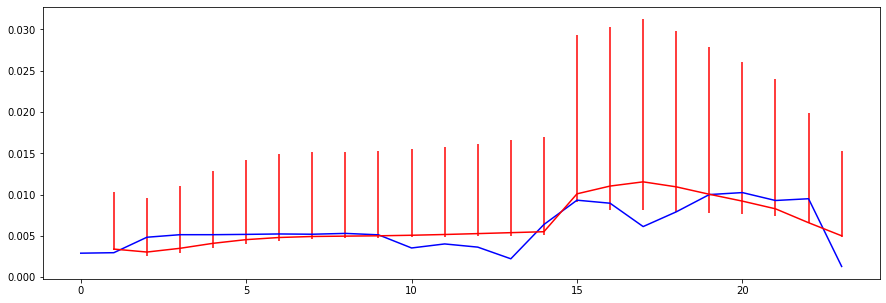

In [46]:
import scipy.stats as ss
import matplotlib.pyplot as plt

i = np.random.randint(len(p))
print(i)
params_it = p[i]
dist_it = ss.norm(params_it[:, 0], params_it[:, 1])
mean_it = dist_it.mean()
low_it = dist_it.ppf(0.1)
high_it = dist_it.ppf(0.9)
y_it = y_test[i].reshape(-1)
n = y_test.shape[-2]

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(np.arange(n), y_it, color='b')
# plt.errorbar(np.arange(n), mean_it, color='r')
plt.errorbar(np.arange(n)[1:], mean_it[1:], color='r', yerr=[np.abs(low_it)[1:], high_it[1:]])
# plt.plot(np.arange(n), low_it)
# plt.plot(np.arange(n), high_it)

In [ ]:
params_it[0, 0], params_it[0, 1], dist_it.ppf(0.1)[0]